In [1]:
import pandas as pd 
import numpy as np 
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv("Data/Alcohol_sales.csv",infer_datetime_format=True,index_col="DATE")

/var/folders/j9/2xjjcspd5r3dz1m4ll_0c7m80000gn/T/ipykernel_2735/2051975122.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df=pd.read_csv("Data/Alcohol_sales.csv",infer_datetime_format=True,index_col="DATE")


In [3]:
df.columns

Index(['S4248SM144NCEN'], dtype='object')

In [4]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [5]:
df.rename({'S4248SM144NCEN':"Sales"},inplace=True,axis=1)

In [6]:
df.columns

Index(['Sales'], dtype='object')

In [7]:
df.head(20)

,Sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221
1992-06-01,4529
1992-07-01,4466
1992-08-01,4137
1992-09-01,4126


In [8]:
df.isna().sum()

Sales    0
dtype: int64

In [9]:
df.shape

(325, 1)

n_input: The number of lag observations to use as input to the model.

n_nodes: The number of nodes to use in the hidden layer.

n_epochs: The number of times to expose the model to the whole training dataset.

n_batch: The number of samples within an epoch after which the weights are updated.

In [10]:
n_input=12
n_node=100
n_epochs=100

In [11]:
def train_test_split(data,n_test):
    return data[:-n_test],data[-n_test:]

In [12]:
len(df.values)

325

Transform time series data into a supervised learning format for time series forecasting. The general idea behind this transformation is to create lagged versions of the input series to predict future values.

In [13]:
def series_to_supervised(data,n_in,n_out=1):
    df=pd.DataFrame(data)

    cols=list()
    #Creating Lagged Inputs (t-n to t-1)
    for i in range(n_in,0,-1):
        cols.append(df.shift(i))
    #Creating Forecast Outputs (t, t+1, ..., t+n)
    for j in range(0,n_out):
        cols.append(df.shift(-j))


    
    combined_df=pd.concat(cols,axis=1)

    combined_df.dropna(inplace=True)

    lag_columns=[f'lag{i}' for i in range(n_in, 0, -1)]
    forecast_columns=[f'forecast' for _ in range(n_out)]

    combined_df.columns=lag_columns+forecast_columns

    return combined_df

series_to_supervised(df.values, 12)

        

,lag12,lag11,lag10,lag9,lag8,lag7,lag6,lag5,lag4,lag3,lag2,lag1,forecast
12,3459.0,3458.0,4002.0,4564.0,4221.0,4529.0,4466.0,4137.0,4126.0,4259.0,4240.0,4936.0,3031
13,3458.0,4002.0,4564.0,4221.0,4529.0,4466.0,4137.0,4126.0,4259.0,4240.0,4936.0,3031.0,3261
14,4002.0,4564.0,4221.0,4529.0,4466.0,4137.0,4126.0,4259.0,4240.0,4936.0,3031.0,3261.0,4160
15,4564.0,4221.0,4529.0,4466.0,4137.0,4126.0,4259.0,4240.0,4936.0,3031.0,3261.0,4160.0,4377
16,4221.0,4529.0,4466.0,4137.0,4126.0,4259.0,4240.0,4936.0,3031.0,3261.0,4160.0,4377.0,4307
...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,11907.0,12711.0,13261.0,14265.0,9564.0,10415.0,12683.0,11919.0,14138.0,14583.0,12640.0,14257.0,12396
321,12711.0,13261.0,14265.0,9564.0,10415.0,12683.0,11919.0,14138.0,14583.0,12640.0,14257.0,12396.0,13914
322,13261.0,14265.0,9564.0,10415.0,12683.0,11919.0,14138.0,14583.0,12640.0,14257.0,12396.0,13914.0,14174
323,14265.0,9564.0,10415.0,12683.0,11919.0,14138.0,14583.0,12640.0,14257.0,12396.0,13914.0,14174.0,15504


In [14]:
train, test = train_test_split(df, 21)

print(f"train shape : {train.shape}, test shape : {test.shape}")

train shape : (304, 1), test shape : (21, 1)


In [15]:
data=series_to_supervised(train,n_input)
data.shape

(292, 13)

In [16]:
train_x, train_y=data.iloc[:,:-1],data.iloc[:,-1]

In [17]:
train_x.shape

(292, 12)

In [30]:
#define model

class TimeSeriesModel(nn.Module):

    def __init__(self,n_input,n_nodes)->None:
        super().__init__()
        self.lm_linear=nn.Sequential(
            nn.Linear(in_features=n_input, out_features=n_nodes),
            nn.ReLU(),
            nn.Linear(in_features=n_node,out_features=1),
        )
    def forward(self,X):
        B,T =X.shape 
        logits=self.lm_linear(X)
        return logits
    



In [31]:
n_inputs=12
n_node=100
mlp_model=TimeSeriesModel(n_input,n_node)

In [32]:
criterion=nn.MSELoss()# Mean Squared Loss
optimizer=optim.Adam(mlp_model.parameters())

In [34]:
train_x,train_y=torch.tensor(train_x.values,dtype=torch.float32),torch.tensor(train_y.values,dtype=torch.float32)

In [36]:
train_x

tensor([[ 3459.,  3458.,  4002.,  ...,  4259.,  4240.,  4936.],
        [ 3458.,  4002.,  4564.,  ...,  4240.,  4936.,  3031.],
        [ 4002.,  4564.,  4221.,  ...,  4936.,  3031.,  3261.],
        ...,
        [10321., 12107., 11420.,  ..., 13016., 14421.,  9043.],
        [12107., 11420., 12238.,  ..., 14421.,  9043., 10452.],
        [11420., 12238., 13681.,  ...,  9043., 10452., 12481.]])

In [50]:
train_y

tensor([ 3031.,  3261.,  4160.,  4377.,  4307.,  4696.,  4458.,  4457.,  4364.,
         4236.,  4500.,  4974.,  3075.,  3377.,  4443.,  4261.,  4460.,  4985.,
         4324.,  4719.,  4374.,  4248.,  4784.,  4971.,  3370.,  3484.,  4269.,
         3994.,  4715.,  4974.,  4223.,  5000.,  4235.,  4554.,  4851.,  4826.,
         3699.,  3983.,  4262.,  4619.,  5219.,  4836.,  4941.,  5062.,  4365.,
         5012.,  4850.,  5097.,  3758.,  3825.,  4454.,  4635.,  5210.,  5057.,
         5231.,  5034.,  4970.,  5342.,  4831.,  5965.,  3796.,  4019.,  4898.,
         5090.,  5237.,  5447.,  5435.,  5107.,  5515.,  5583.,  5346.,  6286.,
         4032.,  4435.,  5479.,  5483.,  5587.,  6176.,  5621.,  5889.,  5828.,
         5849.,  6180.,  6771.,  4243.,  4952.,  6008.,  5353.,  6435.,  6673.,
         5636.,  6630.,  5887.,  6322.,  6520.,  6678.,  5082.,  5216.,  5893.,
         5894.,  6799.,  6667.,  6374.,  6840.,  5575.,  6545.,  6789.,  7180.,
         5117.,  5442.,  6337.,  6525., 

In [83]:
n_epochs=2
train_losses=[]
test_losses=[]

In [ ]:
for _ in range(n_epochs):
    optimizer.zero_grad() # reset gradient before backprogation
    logits=mlp_model.forward(train_x) #forward pass
    loss=criterion(logits.view(-1),train_y) # calculate trainning loss
    train_losses.append(loss.item()) #store loss for training curve

In [40]:
train_losses

[86260224.0, 86260224.0]

In [ ]:
train_x[-1].tolist() #take last row and convert into list

[11420.0,
 12238.0,
 13681.0,
 10950.0,
 12700.0,
 12272.0,
 11905.0,
 13016.0,
 14421.0,
 9043.0,
 10452.0,
 12481.0]

In [ ]:
train_y[-1]# scalar 

tensor(11491.)

In [57]:
train_y[-1][None] # scalar into 1 d tensor

tensor([11491.])

/var/folders/j9/2xjjcspd5r3dz1m4ll_0c7m80000gn/T/ipykernel_2735/980727816.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test.iloc[1][0]


np.int64(14730)

In [ ]:
with torch.no_grad():
    history=train_x[-1].tolist()+ train_y[-1][None].tolist()
    #print(f"history frist{history}")
    y_pred_values=[]
    y_true=[]
    for i in range(len(test)):

        test_points=torch.tensor(history[-n_input:],dtype=torch.float32).view(1,n_input)
        yhat=mlp_model.forward(test_points)
        history.append(test.iloc[i][0])
        y_pred_values.append(yhat.item())
        y_true.append(test.iloc[i][0])

    y_pred_values=torch.tensor(y_pred_values,dtype=torch.float32)
    y_true=torch.tensor(y_true,dtype=torch.float32)
    test_loss=criterion(y_pred_values,y_true)
    test_losses.append(test_loss.item())

/var/folders/j9/2xjjcspd5r3dz1m4ll_0c7m80000gn/T/ipykernel_2735/2186963365.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test.iloc[i][0])
/var/folders/j9/2xjjcspd5r3dz1m4ll_0c7m80000gn/T/ipykernel_2735/2186963365.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_true.append(test.iloc[i][0])


In [76]:
type(y_pred_values[0])

float

In [77]:
type(y_true[0])

numpy.int64

In [74]:
y_true

[np.int64(13545),
 np.int64(14730),
 np.int64(11416),
 np.int64(13402),
 np.int64(11907),
 np.int64(12711),
 np.int64(13261),
 np.int64(14265),
 np.int64(9564),
 np.int64(10415),
 np.int64(12683),
 np.int64(11919),
 np.int64(14138),
 np.int64(14583),
 np.int64(12640),
 np.int64(14257),
 np.int64(12396),
 np.int64(13914),
 np.int64(14174),
 np.int64(15504),
 np.int64(10718)]

In [79]:
test_losses

[221436656.0]

In [84]:
#complete code 

for _ in range(n_epochs):
    optimizer.zero_grad() # reset gradient before backprogation
    logits=mlp_model.forward(train_x) #forward pass
    loss=criterion(logits.view(-1),train_y) # calculate trainning loss
    train_losses.append(loss.item()) #store loss for training curve
    #validation
    with torch.no_grad():
        history=train_x[-1].tolist()+ train_y[-1][None].tolist()
        #print(f"history frist{history}")
        y_pred_values=[]
        y_true=[]
        for i in range(len(test)):

            test_points=torch.tensor(history[-n_input:],dtype=torch.float32).view(1,n_input)
            yhat=mlp_model.forward(test_points)
            history.append(test.iloc[i][0])
            y_pred_values.append(yhat.item())
            y_true.append(test.iloc[i][0])

        y_pred_values=torch.tensor(y_pred_values,dtype=torch.float32)
        y_true=torch.tensor(y_true,dtype=torch.float32)
        test_loss=criterion(y_pred_values,y_true)
        test_losses.append(test_loss.item())
    loss.backward()
    optimizer.step()    

/var/folders/j9/2xjjcspd5r3dz1m4ll_0c7m80000gn/T/ipykernel_2735/489444971.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(test.iloc[i][0])
/var/folders/j9/2xjjcspd5r3dz1m4ll_0c7m80000gn/T/ipykernel_2735/489444971.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_true.append(test.iloc[i][0])


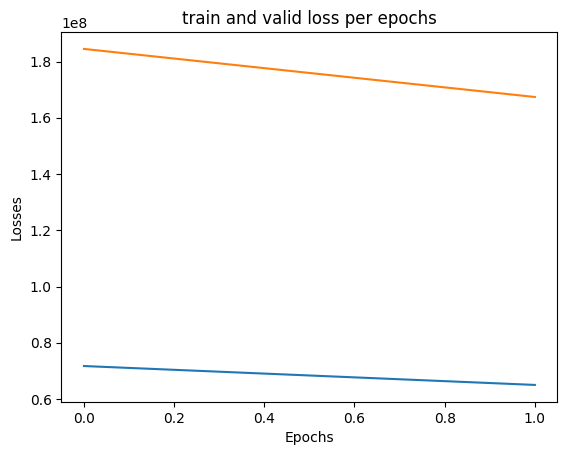

In [85]:
plt.plot(train_losses,label="train Loss")
plt.plot(test_losses,label="Test_losses")

plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("train and valid loss per epochs")
plt.legend

plt.show()